# Uploading libraries that will be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.core.pylabtools import figsize
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from numpy import sort
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
sns.set_context(font_scale = 2)
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Import the data

In [2]:
data = pd.read_excel('forestfires_labelled.xlsx')
print(data)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  label
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0      0
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0      0
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0      0
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2      0
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0      0
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0      1
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0      1
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0      1
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0      0
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0      0

[517 rows x 13 columns]


In [70]:
print(data.shape)

(517, 13)


# What are the chances of forest fire in each month?

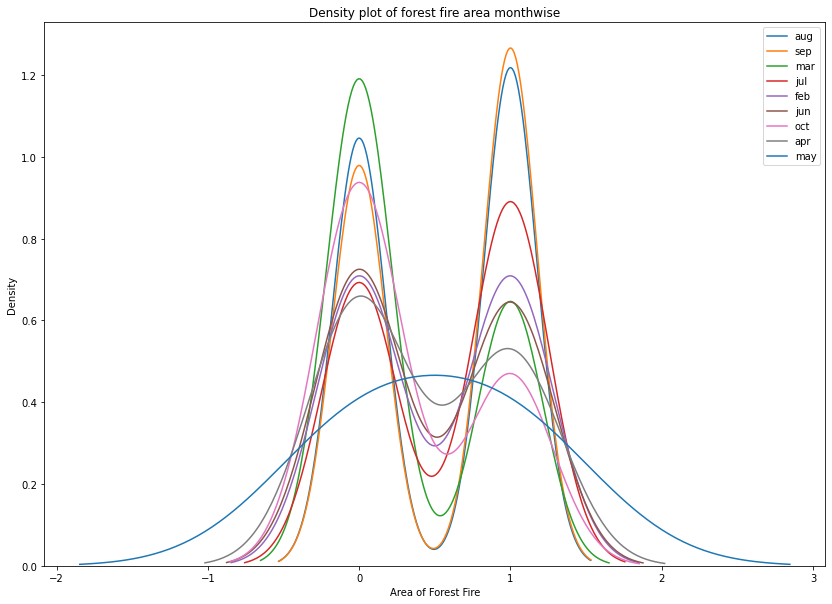

In [7]:
months = data['month'].value_counts()
months = list(months.index)

figsize(14, 10)
for m in months:
    subset = data[(data['month'] == m)]
    
    sns.kdeplot(subset['label'], label=m)
    plt.xlabel('Area of Forest Fire')
    plt.ylabel('Density')
    plt.legend()
    plt.title('Density plot of forest fire area monthwise')

# Is there any feature which is crucial in prediction of forest fire?

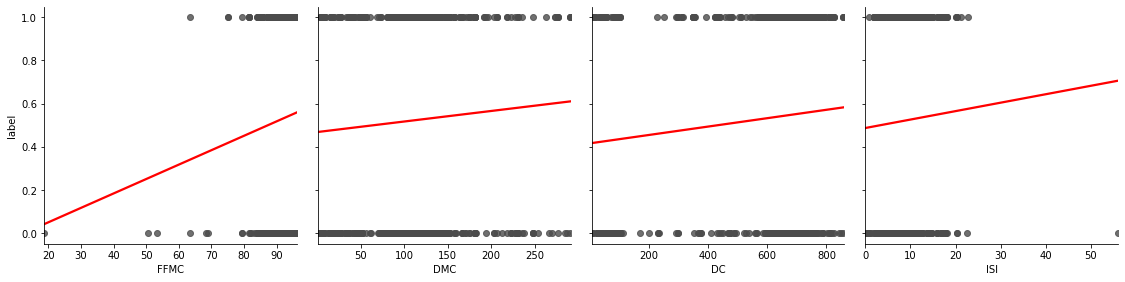

In [72]:
g = sns.PairGrid(data, y_vars=["label"], x_vars=["FFMC", "DMC", "DC", "ISI"], height=4)
g.map(sns.regplot, color=".3", ci=None, line_kws={'color':'r'})

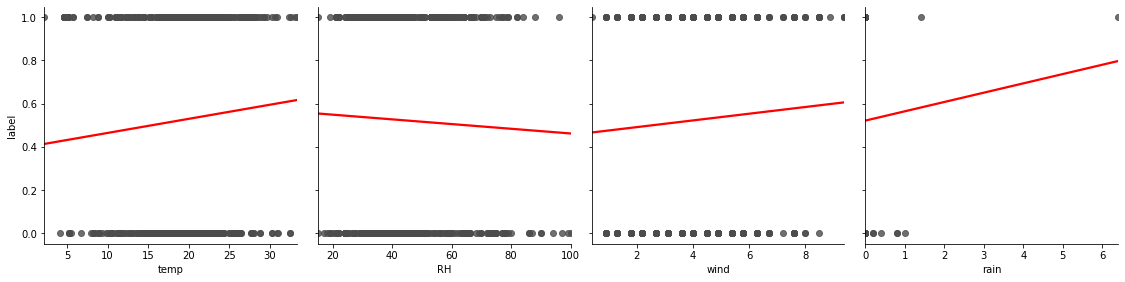

In [73]:
g = sns.PairGrid(data, y_vars=["label"], x_vars=["temp", "RH", "wind", "rain"], height=4)
g.map(sns.regplot, color=".3", ci=None, line_kws={'color':'r'})

In [3]:
#Encoding month and day to integer
lbl = preprocessing.LabelEncoder()
data['month'] = lbl.fit_transform(data['month'].astype(str))
data['day'] = lbl.fit_transform(data['day'].astype(str))
print(data)

     X  Y  month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  label
0    7  5      7    0  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0      0
1    7  4     10    5  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0      0
2    7  4     10    2  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0      0
3    8  6      7    0  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2      0
4    8  6      7    3  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0      0
..  .. ..    ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3      1    3  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0      1
513  2  4      1    3  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0      1
514  7  4      1    3  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0      1
515  1  4      1    2  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0      0
516  6  3      9    5  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0      0

[517 rows x 13 columns]


# Training, evaluating and plotting feature importance

In [4]:
def xgbTrain() :
        # plot feature importance using built-in function
        #xgb parameters
        grid = {'verbosity':0}
        #Get number of columns in data
        colnum = len(data.columns)
        colnum -= 1
        # split data into X and y
        X = data.iloc[:,0:colnum]
        y = data.iloc[:,colnum]
        # split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
        # fit model no training data
        model = XGBClassifier()
        model.set_params(**grid)
        model.fit(X_train, y_train)
        # plot feature importance
        plot_importance(model)
        pyplot.show()
        # make predictions for test data and evaluate
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        # Fit model using each importance as a threshold
        thresholds = sort(model.feature_importances_)
        for thresh in thresholds:
            # select features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_X_train = selection.transform(X_train)
            # train model
            selection_model = XGBClassifier()
            selection_model.fit(select_X_train, y_train)
            # eval model
            select_X_test = selection.transform(X_test)
            y_pred = selection_model.predict(select_X_test)
            predictions = [round(value) for value in y_pred]
            accuracy = accuracy_score(y_test, predictions)
            print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

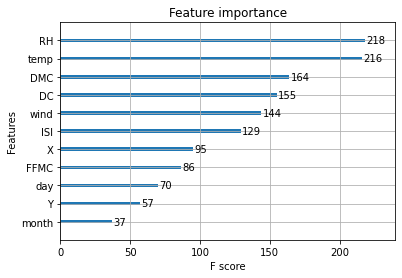

Accuracy: 59.06%
Thresh=0.000, n=12, Accuracy: 59.06%
Thresh=0.063, n=11, Accuracy: 59.06%
Thresh=0.069, n=10, Accuracy: 59.06%
Thresh=0.076, n=9, Accuracy: 55.56%
Thresh=0.082, n=8, Accuracy: 57.31%
Thresh=0.085, n=7, Accuracy: 60.23%
Thresh=0.089, n=6, Accuracy: 60.82%
Thresh=0.094, n=5, Accuracy: 56.14%
Thresh=0.099, n=4, Accuracy: 56.14%
Thresh=0.100, n=3, Accuracy: 54.97%
Thresh=0.108, n=2, Accuracy: 53.80%
Thresh=0.134, n=1, Accuracy: 51.46%


In [5]:
xgbTrain()

## Data examples can be classified into four types:
### 1. True Positive(TP) : Positive examples that are predicted correctly
### 2. True Negative(TN) : Negative examples that are predicted correctly
### 3. False Positive(FP) : Positive examples that are predicted incorrectly
### 4. False Negative(FN): Negative examples that are predicted incorrectly

### F-score = TP/ (TP+0.5(FP + FN))

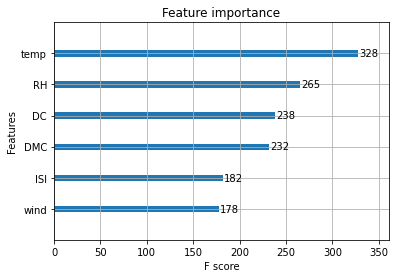

Accuracy: 54.97%
Thresh=0.148, n=6, Accuracy: 54.97%
Thresh=0.164, n=5, Accuracy: 61.99%
Thresh=0.165, n=4, Accuracy: 56.14%
Thresh=0.169, n=3, Accuracy: 54.97%
Thresh=0.171, n=2, Accuracy: 58.48%
Thresh=0.183, n=1, Accuracy: 52.63%


In [6]:
data.drop(['month','Y','day','FFMC','X', 'rain'],axis=1,inplace=True)
xgbTrain()

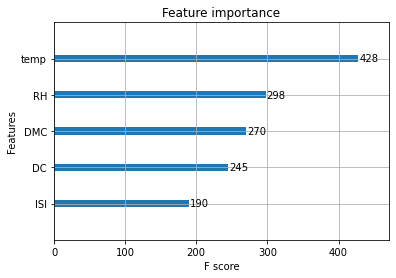

Accuracy: 61.99%
Thresh=0.187, n=5, Accuracy: 61.99%
Thresh=0.193, n=4, Accuracy: 59.65%
Thresh=0.200, n=3, Accuracy: 55.56%
Thresh=0.208, n=2, Accuracy: 59.06%
Thresh=0.211, n=1, Accuracy: 54.97%


In [7]:
data.drop(['wind'],axis=1,inplace=True)
xgbTrain()

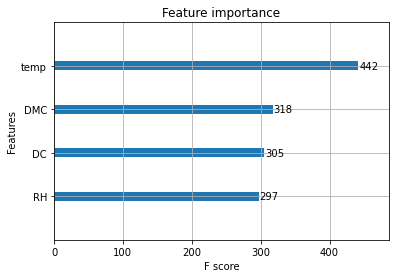

Accuracy: 58.48%
Thresh=0.231, n=4, Accuracy: 58.48%
Thresh=0.249, n=3, Accuracy: 62.57%
Thresh=0.256, n=2, Accuracy: 59.06%
Thresh=0.264, n=1, Accuracy: 54.39%


In [8]:
data.drop(['ISI'],axis=1,inplace=True)
xgbTrain()

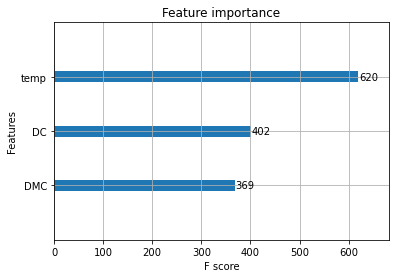

Accuracy: 59.06%
Thresh=0.313, n=3, Accuracy: 59.06%
Thresh=0.332, n=2, Accuracy: 59.65%
Thresh=0.355, n=1, Accuracy: 54.97%


In [9]:
data.drop(['RH'],axis=1,inplace=True)
xgbTrain()

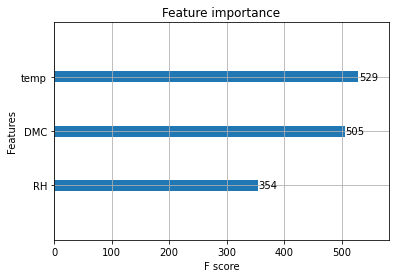

Accuracy: 64.33%
Thresh=0.323, n=3, Accuracy: 64.33%
Thresh=0.334, n=2, Accuracy: 58.48%
Thresh=0.343, n=1, Accuracy: 54.39%


In [10]:
data = pd.read_excel('forestfires_labelled.xlsx')
data.drop(['month','Y','day','FFMC','X', 'rain', 'wind', 'ISI', 'DC'],axis=1,inplace=True)
xgbTrain()

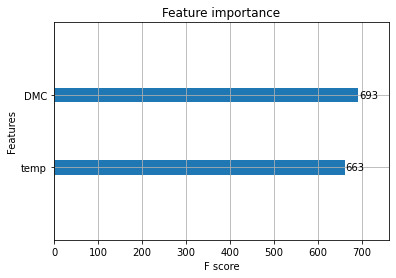

Accuracy: 57.31%
Thresh=0.494, n=2, Accuracy: 57.31%
Thresh=0.506, n=1, Accuracy: 54.39%


In [11]:
data.drop(['RH'],axis=1,inplace=True)
xgbTrain()

## The three feature set {temp, DMC, RH} gives the maximum accuracy. Because two set feature {DMC, temp} reduces accuracy by significant margins as shown in the cell above